### Import package

In [1]:

!pip install xtarfile

  Preparing metadata (setup.py) ... done
  Created wheel for xtarfile: filename=xtarfile-0.2.1-py3-none-any.whl size=8056 sha256=b81216883cdbddae9ba0468363f17b95d9854aa3138e6031bdee8e09354b6e38
  Stored in directory: /root/.cache/pip/wheels/73/de/d6/def0eebfc3d5adb3a866d1bd9ae45649e07e6cffb284314a00
Successfully built xtarfile


In [2]:
START_TOKEN="\t"
END_TOKEN="\n"

In [3]:
# General Utilities
import os
from os.path import exists
import random
import time
import re
import string
import csv

# Numerical and Data Handling
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.font_manager import FontProperties

# Word Cloud
from wordcloud import WordCloud, STOPWORDS

# Machine Learning
import keras
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K


# **Attention mechanisms**

In [4]:
"""
This module implements two types of attention mechanisms:
- Luong Attention
- Bahdanau Attention
"""
import tensorflow as tf
from tensorflow.keras import layers

# --- Luong Attention (Fixed) ---
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W = layers.Dense(units)

    def call(self, query, values):
        # Handle case when query is a list of tensors (from LSTM states)
        if isinstance(query, list):
            # Use only the hidden state (first element), not the cell state
            query = query[0]

        # Reshape query to [batch_size, 1, hidden_size]
        query_with_time_axis = tf.expand_dims(query, 1)

        # Calculate attention scores
        # [batch_size, 1, hidden_size] x [batch_size, hidden_size, seq_len] = [batch_size, 1, seq_len]
        values_transposed = tf.transpose(values, perm=[0, 2, 1])
        score = tf.matmul(query_with_time_axis, values_transposed)

        # Apply softmax to get attention weights
        # [batch_size, 1, seq_len]
        attention_weights = tf.nn.softmax(score, axis=2)

        # Calculate context vector
        # [batch_size, 1, seq_len] x [batch_size, seq_len, hidden_size] = [batch_size, 1, hidden_size]
        context_vector = tf.matmul(attention_weights, values)
        context_vector = tf.squeeze(context_vector, axis=1)  # [batch_size, hidden_size]

        return context_vector, attention_weights

# --- Bahdanau Attention (Unchanged) ---
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, verbose=0):
        super().__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.verbose = verbose

    def call(self, query, values):
        # Handle case when query is a list of tensors (from LSTM states)
        if isinstance(query, list):
            # Use only the hidden state (first element), not the cell state
            query = query[0]

        query_time = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_time) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# **Helper functions**

In [6]:
START_TOKEN = "\t"
END_TOKEN = "\n"

def downloadDataSet():
    cwd = os.getcwd()
    if not exists('./dakshina_dataset_v1.0.tar'):
        print("downloading....")
        os.system('curl -SL https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar > dakshina_dataset_v1.0.tar')
        print("download complete")

    if not exists('./dakshina_dataset_v1.0/'):
        print("extracting...")
        with tarfile.open('dakshina_dataset_v1.0.tar', mode='r') as archive:
            archive.extractall()
        print("extraction complete")

    print("You are all set.")

def get_files(language):
    base_path = f'./dakshina_dataset_v1.0/{language}/lexicons/'
    return (
        f'{base_path}{language}.translit.sampled.train.tsv',
        f'{base_path}{language}.translit.sampled.dev.tsv',
        f'{base_path}{language}.translit.sampled.test.tsv'
    )

def tokenize(lang, tokenizer=None):
    """Tokenizes characters using Keras tokenizer"""
    if tokenizer is None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
        tokenizer.fit_on_texts(lang)

    sequences = tokenizer.texts_to_sequences(lang)
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')
    return padded, tokenizer

def preprocess_data(fpath, ip_tokenizer=None, tgt_tokenizer=None):
    df = pd.read_csv(fpath, sep='\t', header=None)
    df[0] = df[0].apply(lambda x: START_TOKEN + x + END_TOKEN)

    ip_tensor, ip_tokenizer = tokenize(df[1].astype(str).tolist(), ip_tokenizer)
    tgt_tensor, tgt_tokenizer = tokenize(df[0].astype(str).tolist(), tgt_tokenizer)

    data = tf.data.Dataset.from_tensor_slices((ip_tensor, tgt_tensor))
    data = data.shuffle(buffer_size=len(data))

    return data, ip_tokenizer, tgt_tokenizer


In [ ]:
"""This function creates the appropriate RNN layer based on the type specified"""
def get_layer(layer_type, units, dropout, return_sequences=True, return_state=True):
    if layer_type == 'rnn':
        return layers.SimpleRNN(units,
                            return_sequences=return_sequences,
                            return_state=return_state,
                            dropout=dropout)
    elif layer_type == 'gru':
        return layers.GRU(units,
                      return_sequences=return_sequences,
                      return_state=return_state,
                      dropout=dropout)
    elif layer_type == 'lstm':
        return layers.LSTM(units,
                       return_sequences=return_sequences,
                       return_state=return_state,
                       dropout=dropout)
    else:
        raise ValueError(f"Unknown layer type: {layer_type}")

In [7]:
class Parameters():
  def  __init__(self,  language='te',encoder_layers=1,decoder_layers=1,embedding_dim=128,\
                layer_type='lstm', units=128, dropout=0.5, attention=False,attention_type="Luong",batch_size=128,\
                apply_beam_search=False,apply_teacher_forcing=False,teacher_forcing_ratio=1,\
                 save_outputs=None,epochs=5,wandb=None,beamWidth=5,restoreBestModel=True,\
                 patience=2,encoder_vocab_size=64,decoder_vocab_size=64):
        self.language = language
        self.embedding_dim = embedding_dim
        self.encoder_layers=encoder_layers
        self.decoder_layers=decoder_layers
        self.layer_type = layer_type
        self.units = units
        self.dropout = dropout
        self.attention = attention
        self.stats = []
        self.wandb=wandb
        self.epochs=epochs
        self.batch_size = 128
        self.apply_beam_search = apply_beam_search
        self.batch_size = batch_size
        self.apply_teacher_forcing=apply_teacher_forcing
        self.save_outputs=save_outputs
        self.restoreBestModel=restoreBestModel
        self.attention_type=attention_type
        self.patience=patience
        self.encoder_vocab_size=encoder_vocab_size
        self.decoder_vocab_size=decoder_vocab_size
        self.teacher_forcing_ratio=teacher_forcing_ratio

# **Encoder**

In [8]:
"""This class contains all functions to add Encoder layers
Input: Param
This variable contains all configuration details, with focus on:
- layer_type
- encoder_layers
- units
- dropout
"""
class Encoder(tf.keras.Model):
    def __init__(self, param):
        # Configurations
        super(Encoder, self).__init__()
        self.layer_type = param.layer_type
        self.n_layers = param.encoder_layers
        self.units = param.units
        self.dropout = param.dropout
        self.embedding = tf.keras.layers.Embedding(param.encoder_vocab_size, param.embedding_dim, trainable=True)

        # Create Recurrent Layers
        self.create_rnn_layers()

    def call(self, x, hidden):
        # Apply embedding
        x = self.embedding(x)

        # Process through RNN layers
        states = []

        # First layer takes the input sequence and initial state
        if self.layer_type == 'lstm':
            output, h, c = self.rnn_layers[0](x, initial_state=hidden)
            current_state = [h, c]
        else:
            output, h = self.rnn_layers[0](x, initial_state=hidden)
            current_state = [h]

        states.extend(current_state)

        # Process remaining layers
        for i in range(1, self.n_layers):
            if self.layer_type == 'lstm':
                output, h, c = self.rnn_layers[i](output)
                current_state = [h, c]
            else:
                output, h = self.rnn_layers[i](output)
                current_state = [h]

            states.extend(current_state)

        return output, states

    """Create Encoder layers"""
    def create_rnn_layers(self):
        self.rnn_layers = []
        # Add one or more encoder layers
        for i in range(self.n_layers):
            # All layers should return sequences for stacking, except maybe the last one
            # All layers should return state
            return_seq = True  # We want sequences from all encoder layers

            rnn_layer = get_layer(self.layer_type, self.units, self.dropout,
                                   return_sequences=return_seq,
                                   return_state=True)
            self.rnn_layers.append(rnn_layer)

    def initialize_hidden_state(self, batch_size):
        if self.layer_type != "lstm":
            return [tf.zeros((batch_size, self.units))]
        else:
            return [tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))]

# **Decoder**

In [9]:
"""This class contains all functions to add Decoder layers
Input: Param
This variable contains all configuration details, focusing on:
- layer_type
- decoder_layers
- units
- dropout
- attention [True, False]
- attention_type [Luong, Bahdanau]
"""
class Decoder(tf.keras.Model):
    def __init__(self, param):
        super(Decoder, self).__init__()

        # Basic configurations
        self.layer_type = param.layer_type
        self.n_layers = param.decoder_layers
        self.units = param.units
        self.dropout = param.dropout

        # Following configuration useful in case of attention enabled model
        # attention_type = [Luong, Bahdanau]
        self.attention = param.attention
        self.attention_type = param.attention_type

        # Add embedding layers
        self.embedding_layer = layers.Embedding(input_dim=param.decoder_vocab_size,
                                               output_dim=param.embedding_dim, trainable=True)

        self.dense = layers.Dense(param.decoder_vocab_size, activation="softmax")

        # We won't need a Flatten layer if we correctly handle the dimensions
        # self.flatten = layers.Flatten()

        # Verify if we want to add attention layers
        # it could be either Luong or Bahdanau attention
        if self.attention:
            if self.attention_type == "Luong":
                self.attention_layer = LuongAttention(self.units)
            else:
                self.attention_layer = BahdanauAttention(self.units)

        # Add one/more recurrent layers based on configurations
        self.create_rnn_layers()

    def call(self, x, hidden, enc_out=None):
        # Add embedding input layer
        x = self.embedding_layer(x)  # [batch_size, 1, embedding_dim]

        # Verify if attention layer needs to be added
        if self.attention:
            context_vector, attention_weights = self.attention_layer(hidden, enc_out)
            x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
        else:
            attention_weights = None

        # Process through RNN layers
        states = []

        # First layer takes the input and initial hidden state
        if self.layer_type == 'lstm':
            # For LSTM, hidden is [h, c] for each layer
            h_states = hidden[::2]  # Get all h states
            c_states = hidden[1::2]  # Get all c states
            initial_state = [h_states[0], c_states[0]]

            output, h, c = self.rnn_layers[0](x, initial_state=initial_state)
            current_state = [h, c]
        else:
            # For GRU/RNN, hidden is [h] for each layer
            initial_state = hidden[0]
            output, h = self.rnn_layers[0](x, initial_state=initial_state)
            current_state = [h]

        states.extend(current_state)

        # Process remaining layers, but handle differently based on return_sequences
        for i in range(1, self.n_layers):
            # For interior layers, pass the output sequence
            # For the last layer, we might not need sequences
            if i < self.n_layers - 1:  # Not the last layer
                if self.layer_type == 'lstm':
                    initial_state = [h_states[i], c_states[i]]
                    output, h, c = self.rnn_layers[i](output, initial_state=initial_state)
                    current_state = [h, c]
                else:
                    initial_state = hidden[i]
                    output, h = self.rnn_layers[i](output, initial_state=initial_state)
                    current_state = [h]
            else:  # Last layer
                if self.layer_type == 'lstm':
                    initial_state = [h_states[i], c_states[i]]
                    output, h, c = self.rnn_layers[i](output, initial_state=initial_state)
                    current_state = [h, c]
                else:
                    initial_state = hidden[i]
                    output, h = self.rnn_layers[i](output, initial_state=initial_state)
                    current_state = [h]

            states.extend(current_state)

        # Apply dense layer to get vocabulary distribution
        # output shape should be [batch_size, units]
        output = self.dense(output)

        return output, states, attention_weights

    # Create decoder layers
    def create_rnn_layers(self):
        self.rnn_layers = []

        # Add decoder layers
        for i in range(self.n_layers - 1):
            # Interior layers return sequences for stacking
            self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                           return_sequences=True,
                                           return_state=True))

        # Last layer does not need to return sequences if dense layer expects [batch_size, units]
        self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                       return_sequences=False,
                                       return_state=True))

# **SequenceTOSequence**

In [10]:
class SequenceTOSequence():
    def __init__(self, parameters):

        #Basic configurations
        self.param=parameters
        self.embedding_dim = parameters.embedding_dim
        self.encoder_layers = parameters.encoder_layers
        self.decoder_layers = parameters.decoder_layers
        self.layer_type = parameters.layer_type
        self.units = parameters.units
        self.dropout = parameters.dropout
        self.batch_size = parameters.batch_size

        #Add information regarding attention layer
        self.attention = parameters.attention
        self.attention_type = parameters.attention_type

        self.stats = []

        self.apply_beam_search = parameters.apply_beam_search

        #Early stop conditions
        self.patience=parameters.patience
        self.restoreBestModel=parameters.restoreBestModel

        #teacher forcing
        self.apply_teacher_forcing=parameters.apply_teacher_forcing
        self.teacher_forcing_ratio=parameters.teacher_forcing_ratio

    #Build model Add specific optimizers
    def build(self, loss, metric,optimizer='adam',lr=0.001):
        self.loss = loss

        #Select specific optimizer
        if(optimizer=='adam'):
          self.optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
        if(optimizer=='nadam'):
          self.optimizer=tf.keras.optimizers.Nadam(learning_rate=lr)
        else:
          self.optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr)

        self.metric = metric

    def set_vocabulary(self, input_tokenizer, targ_tokenizer):
        self.input_tokenizer = input_tokenizer
        self.targ_tokenizer = targ_tokenizer
        self.create_model()

    """This procedure used to define Encoder Decoder Layer"""
    def create_model(self):

        encoder_vocab_size = len(self.input_tokenizer.word_index) + 1
        decoder_vocab_size = len(self.targ_tokenizer.word_index) + 1
        self.param.encoder_vocab_size=encoder_vocab_size
        self.param.decoder_vocab_size=decoder_vocab_size
        #Add Encoder layer

        self.encoder = Encoder(self.param)

        #Create decode with or without any attention layer
        #Check following properties to add attention
        # self.attention
        # self.attention_type
        self.decoder = Decoder(self.param)


    @tf.function
    def train(self, input, target, enc_state):

        loss = 0

        with tf.GradientTape() as tape:

            enc_out, enc_state = self.encoder(input, enc_state)

            dec_state = enc_state
            dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

            apply_teacher_forcing=False
            #decide whether to use teacher forcing
            if random.random() < self.teacher_forcing_ratio:
              apply_teacher_forcing=True
            ## We use Teacher forcing to train the network
            ## Each target at timestep t is passed as input for timestep t + 1
            if  (apply_teacher_forcing==True):
                #Apply teacher forcing
                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)
                    #As teacher forcing  applied we pass next target as decoder input
                    dec_input = tf.expand_dims(target[:,t], 1)

            else:
                #Without teacher forcing

                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)
                    #As teacher forcing not applied we pass decoder input as whatever we predict
                    preds = tf.argmax(preds, 1)
                    dec_input = tf.expand_dims(preds, 1)


            batch_loss = loss / target.shape[1]

            variables = self.encoder.variables + self.decoder.variables
            gradients = tape.gradient(loss, variables)

            self.optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss, self.metric.result()




    def fit(self, dataset, val_dataset, batch_size=128, epochs=5, wandb=None,apply_teacher_forcing=True, teacher_forcing_ratio=0.7):

        self.batch_size = batch_size
        self.apply_teacher_forcing = apply_teacher_forcing
        self.teacher_forcing_ratio=teacher_forcing_ratio
        #Prepare chunk of data based on batch size provided
        steps_per_epoch = len(dataset) // self.batch_size
        #steps_per_epoch_val = len(val_dataset) // self.batch_size

        dataset = dataset.batch(self.batch_size, drop_remainder=False)
        #val_dataset = val_dataset.batch(self.batch_size, drop_remainder=False)


        sample_inp, sample_targ = next(iter(dataset))
        self.max_target_len = sample_targ.shape[1]
        self.max_input_len = sample_inp.shape[1]

        #Store Encoder ,decoder details in case model get good accuracy
        #Will be useful to restore best model
        self.bestEncoder=self.encoder
        self.bestDecoder=self.decoder
        self.bestoptimizer=self.optimizer

        accuracyDegradePatience=0
        self.oldaccuracy=0
        for epoch in  tqdm(range(1, epochs+1), total = epochs,desc="Epochs "):

            if(accuracyDegradePatience>=self.patience):
                if(self.restoreBestModel==True):
                    self.encoder=self.bestEncoder
                    self.decoder=self.bestDecoder
                    self.optimizer=self.bestoptimizer
                break
            ## Training loop ##
            total_loss = 0
            total_acc = 0
            self.metric.reset_state()

            starting_time = time.time()
            enc_state = self.encoder.initialize_hidden_state(self.batch_size)



            for batch, (input, target) in enumerate(dataset.take(steps_per_epoch)):
                #Accumulate loss and accurecy for each batch
                batch_loss, acc = self.train(input, target, enc_state)
                total_loss += batch_loss
                total_acc += acc
            #Calculate validation accurecy for current Epoch

            avg_acc = total_acc / steps_per_epoch
            avg_loss = total_loss / steps_per_epoch

            # Validation loop ##
            total_val_loss = 0
            total_val_acc = 0
            self.metric.reset_state()

            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            #Process data in batches

            avg_val_loss, avg_val_acc = self.evaluate(val_dataset,batch_size=self.batch_size)



            #Verify if model performance degrading.add()
            #In case train accurecy improved but no significant imprrovement in validation
            #Add condition for early stopping
            #Restore best model based on the input
            if(self.oldaccuracy>avg_val_acc):
              accuracyDegradePatience+=1
            else:
              self.bestEncoder=self.encoder
              self.bestDecoder=self.decoder
              self.bestoptimizer=self.optimizer
              self.oldaccuracy=avg_val_acc
              accuracyDegradePatience=0
            print( "\nTrain Loss: {0:.4f} Train Accuracy: {1:.4f} Validation Loss: {2:.4f} Validation Accuracy: {3:.4f}".format(avg_loss, avg_acc*100, avg_val_loss, avg_val_acc*100))

            time_taken = time.time() - starting_time

            #Add logs for WanDb
            self.stats.append({"epoch": epoch,
                            "train_loss": avg_loss,
                            "val_loss": avg_val_loss,
                            "train_acc": avg_acc*100,
                            "val_acc": avg_val_acc*100,
                            "training time": time_taken})

            #Log to wanDB
            if not (wandb is None):
                wandb.log(self.stats[-1])

            print(f"\nTime taken for the epoch {time_taken:.4f}")


        print("\nModel trained successfully !!")
    @tf.function
    def validation(self, inp, trgt, encoder_state):
        #Custom validation

        loss = 0
        #encoder input
        encoder_output, encoder_state = self.encoder(inp, encoder_state)

        #Set initial state of decoder from encoder state
        decoder_state = encoder_state
        decoder_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

        for t in range(1, trgt.shape[1]):
            #Get decoder prediction
            prediction, decoder_state, _ = self.decoder(decoder_input, decoder_state, encoder_output)
            loss += self.loss(trgt[:,t], prediction)
            self.metric.update_state(trgt[:,t], prediction)

            prediction = tf.argmax(prediction, 1)
            decoder_input = tf.expand_dims(prediction, 1)

        batch_loss = loss / trgt.shape[1]

        return batch_loss, self.metric.result()
    def evaluate(self, test_dataset, batch_size=None):
        """Evaluate our model on test data"""
        if batch_size is not None:
            self.batch_size = batch_size

        #prepare chuck of data based on the batch size
        steps_per_epoch_test = len(test_dataset) // batch_size
        test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

        total_test_loss = 0
        total_test_acc = 0
        self.metric.reset_state()

        enc_state = self.encoder.initialize_hidden_state(self.batch_size)

        #print("\nRunning test dataset through the model...\n")
        #Run in batches based on the input batch size
        for batch, (input, target) in enumerate(test_dataset.take(steps_per_epoch_test)):
            batch_loss, acc = self.validation(input, target, enc_state)
            total_test_loss += batch_loss
            total_test_acc += acc

        #Caculate avarage  test accuracy and loss
        avg_test_acc = total_test_acc / steps_per_epoch_test
        avg_test_loss = total_test_loss / steps_per_epoch_test

        #Display details
        #print(f"Test Loss: {avg_test_loss:.4f} Test Accuracy: {avg_test_acc:.4f}")

        return avg_test_loss, avg_test_acc

    """ This function used to translate english world to respective language"""

    def translate(self, word, get_heatmap=False):
        #start and end token for input word
        start="\t"
        end="\n"
        word =start  + word + end

        #Tokenize input and perform  preprocessing
        inputs = self.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.max_input_len,
                                                               padding="post")

        result = ""
        att_wts = []

        #Process input through encoder
        enc_state = self.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.encoder(inputs, enc_state)

        # Set initial decoder sate to encoder state
        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index[start]]*1, 1)

        #Run the loop for maximum word size the target language can have
        #We get this data during training
        for t in range(1, self.max_target_len):

            preds, dec_state, attention_weights = self.decoder(dec_input, dec_state, enc_out)

            #Add attention weights which is useful for generating attention heatmaps
            if get_heatmap:
                att_wts.append(attention_weights)

            #Pass the current prediction as input to next iteration
            preds = tf.argmax(preds, 1)

            #Accumulate target words

            next_char = self.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char

            #If we receive end token stop the loop
            if next_char == end:
                break


            #Decoder input for next iteration
            dec_input = tf.expand_dims(preds, 1)
        return result[:-1], att_wts[:-1]



### Data Preprocessing

In [12]:

START_TOKEN="\t"
END_TOKEN="\n"


In [13]:
downloadDataSet()

downloading....
download complete
extracting...
extraction complete
You are all set.


In [14]:
language="te"
train_dir, val_dir, test_dir = get_files(language)

dataset, input_tokenizer, targ_tokenizer = preprocess_data(train_dir)
val_dataset, _, _ = preprocess_data(val_dir,input_tokenizer,targ_tokenizer)


In [15]:
#train data
dataset, input_tokenizer, targ_tokenizer = preprocess_data(train_dir)

### Train

In [16]:
param=Parameters(language="te",\
                    embedding_dim=256,\
                    encoder_layers=3,\
                    decoder_layers=3,\
                    layer_type='lstm',\
                    units=256,\
                    dropout=0.5,\
                    epochs=15,\
             batch_size=64\
               )
param.apply_teacher_forcing=True
param.teacher_forcing_ratio=1
param.patience=7
param.attention=True
model = SequenceTOSequence(param)
model.set_vocabulary(input_tokenizer, targ_tokenizer)
model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),\
            metric = tf.keras.metrics.SparseCategoricalAccuracy(),\
            optimizer = 'adam',\
            lr=0.001\
            )
model.fit(dataset, val_dataset, epochs=param.epochs, wandb=None,teacher_forcing_ratio=param.teacher_forcing_ratio)



Epochs :   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'luong_attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state', 'seed_generator_4/seed_generator_state', 'seed_generator_5/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
Epochs :   7%|▋         | 1/15 [


Train Loss: 1.1311 Train Accuracy: 62.8217 Validation Loss: 3.2910 Validation Accuracy: 52.2578

Time taken for the epoch 80.0414


Epochs :  13%|█▎        | 2/15 [01:57<11:57, 55.16s/it]


Train Loss: 0.7446 Train Accuracy: 75.5812 Validation Loss: 2.8338 Validation Accuracy: 60.7332

Time taken for the epoch 37.7400


Epochs :  20%|██        | 3/15 [02:36<09:30, 47.56s/it]


Train Loss: 0.5279 Train Accuracy: 82.3777 Validation Loss: 2.4856 Validation Accuracy: 65.8589

Time taken for the epoch 38.5120


Epochs :  27%|██▋       | 4/15 [03:13<07:58, 43.48s/it]


Train Loss: 0.3807 Train Accuracy: 86.9717 Validation Loss: 3.1433 Validation Accuracy: 64.0622

Time taken for the epoch 37.2098


Epochs :  33%|███▎      | 5/15 [03:50<06:50, 41.07s/it]


Train Loss: 0.2782 Train Accuracy: 90.4143 Validation Loss: 1.7617 Validation Accuracy: 77.1542

Time taken for the epoch 36.8084


Epochs :  40%|████      | 6/15 [04:26<05:55, 39.48s/it]


Train Loss: 0.2102 Train Accuracy: 92.7938 Validation Loss: 1.9871 Validation Accuracy: 76.3443

Time taken for the epoch 36.3785


Epochs :  47%|████▋     | 7/15 [05:03<05:07, 38.47s/it]


Train Loss: 0.1656 Train Accuracy: 94.4948 Validation Loss: 1.4905 Validation Accuracy: 81.8483

Time taken for the epoch 36.3962


Epochs :  53%|█████▎    | 8/15 [05:40<04:26, 38.09s/it]


Train Loss: 0.1347 Train Accuracy: 95.5647 Validation Loss: 1.4728 Validation Accuracy: 81.9925

Time taken for the epoch 37.2652


Epochs :  60%|██████    | 9/15 [06:18<03:47, 37.99s/it]


Train Loss: 0.1127 Train Accuracy: 96.2802 Validation Loss: 1.3518 Validation Accuracy: 83.7239

Time taken for the epoch 37.7844


Epochs :  67%|██████▋   | 10/15 [06:55<03:08, 37.72s/it]


Train Loss: 0.0966 Train Accuracy: 96.8481 Validation Loss: 1.2863 Validation Accuracy: 84.7036

Time taken for the epoch 37.0940


Epochs :  73%|███████▎  | 11/15 [07:31<02:29, 37.26s/it]


Train Loss: 0.0846 Train Accuracy: 97.2383 Validation Loss: 1.3243 Validation Accuracy: 84.8199

Time taken for the epoch 36.2231


Epochs :  80%|████████  | 12/15 [08:07<01:50, 36.87s/it]


Train Loss: 0.0748 Train Accuracy: 97.5742 Validation Loss: 1.2119 Validation Accuracy: 86.1371

Time taken for the epoch 35.9661


Epochs :  87%|████████▋ | 13/15 [08:43<01:13, 36.58s/it]


Train Loss: 0.0676 Train Accuracy: 97.8352 Validation Loss: 1.3450 Validation Accuracy: 84.5447

Time taken for the epoch 35.9077


Epochs :  93%|█████████▎| 14/15 [09:20<00:36, 36.69s/it]


Train Loss: 0.0607 Train Accuracy: 98.0902 Validation Loss: 1.2836 Validation Accuracy: 86.0422

Time taken for the epoch 36.9596


Epochs : 100%|██████████| 15/15 [09:57<00:00, 39.81s/it]


Train Loss: 0.0553 Train Accuracy: 98.2299 Validation Loss: 1.1205 Validation Accuracy: 87.2718

Time taken for the epoch 36.7471

Model trained successfully !!


### Evaluate Model

In [17]:

def evaluate_samples(model, n=0):

    df = pd.read_csv(test_dir, sep="\t", header=None)

    printLine=True
    source=[]
    actual=[]
    predict=[]
    if(n==0):
      print(f"Evaluating the model on all words\n")
      n=len(df)
      printLine=False
    else:
      df = df.sample(n=n).reset_index(drop=False)
      #print(f"Randomly evaluating the model on {n} words\n")

    for i in range(n):
        word = str(df[1][i])
        source.append(word)
        actual.append(str(df[0][i]))
        predict.append(model.translate(word)[0])
        """if(printLine):
          print(f"Input word: {word}")
          print(f"Actual translation: {str(df[0][i])}")
          print(f"Model translation: {predict[-1]}\n")"""
    return source,actual,predict


In [18]:
source,actual,predict=evaluate_samples(model)

Evaluating the model on all words



In [19]:
match=0
total=0
for i,j in zip(actual,predict):
  total+=1
  if(i==j):
    match+=1

print('word level accuracy '+str(match/total))

word level accuracy 0.4518879415347138


### Predicted Word Visualisation

In [20]:

save="predictions_attention.csv"
df = pd.DataFrame()
df["inputs"] =source
df["targets"] = actual
df["outputs"] = predict
df.to_csv(save)

df = pd.read_csv('predictions_attention.csv')
source=df["inputs"]
actual=df["targets"]
predict=df["outputs"]

In [21]:
from IPython.display import HTML as html_print
from IPython.display import display
def compare_result(predict,actual,word,message="Model with Attention"):
    string1=list(actual)
    string2=list(predict)
    maxstr=None

    minstr=None
    if(len(string1)>len(string2)):
      maxstr=string1
      minstr=string2
    else:
      maxstr=string2
      minstr=string1

    shift=0
    html_str = """
    <br>
    <h2 style="color:#3A363B  ;padding:10px;text-align:left">{}</h2>
    <br>
    <strong  style="color:blue ;padding:10px;text-align:left">WORD:</strong><strong>{}</strong>

    <strong  style="color:green ;padding:10px;text-align:left">ACTUAL:</strong><strong>{}</strong>
     <strong  style="color:red ;padding:10px;text-align:left">PREDICTED:</strong><strong>{}</strong>
      <br>
      <table style="border:2px solid black; border-collapse:collapse">
      <tr>
      <td scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>{}</strong> </td>
      """.format(message,word,actual,predict,actual)
    maxlen=len(maxstr)
    minlen=len(minstr)
    char_html=""
    j=0
    for i in range(maxlen):

        if(j<minlen):
          if(maxstr[i]==minstr[j]):
              char_html+="""<td scope="row" style="background-color:#E3FFE7 ;border:1px solid black;padding:15px;text-align:left"> <strong>{}</strong> </td>""".format(maxstr[i] )
              j+=1
          else:
             if(i+1<maxlen and  maxstr[i+1]==minstr[j]):
                char_html+=""" <td scope="row" style="background-color:#FFF6F7 ; border:1px solid black;padding:15px;text-align:left"> <strong>{}</strong> </td>""".format(maxstr[i] )
                continue
             else:
              j+=1
              char_html+=""" <td scope="row" style="background-color:#FFF6F7 ; border:1px solid black;padding:15px;text-align:left"> <strong>{}</strong> </td>""".format(maxstr[i] )
        else:
          char_html+="""<td scope="row" style="background-color: #FFF6F7 ; border:1px solid black;padding:15px;text-align:left"> <strong>{} </strong></td>""".format(maxstr[i] )

    char_html+="""</tr>"""
    char_html+="""<tr>
      <td scope="row" style="border:1px solid black;background-color:#3498DB;padding:15px;color:white;text-align:left"> <strong>{} </strong></td>""".format(predict)

    j=0
    for i in range(maxlen):

        if(j<minlen):

          if(maxstr[i]==minstr[j]):
            char_html+="""<td scope="row" style="background-color:#E3FFE7 ;border:1px solid black;padding:15px;text-align:left"><strong> {} </strong></td>""".format(minstr[j] )
            j+=1
          else:
             if(i+1<maxlen and  maxstr[i+1]==minstr[j]):
                char_html+="""<td scope="row" style="background-color:#FFF6F7 ; border:1px solid black;padding:15px;text-align:left"> <strong>{}</strong> </td>""".format(' ' )
                continue
             else:

                char_html+="""<td scope="row" style="background-color:#FFF6F7 ; border:1px solid black;padding:15px;text-align:left"> <strong>{}</strong> </td>""".format(minstr[j] )
                j+=1
        else:
          char_html+="""<td scope="row" style="background-color:#FFF6F7  ; border:1px solid black;padding:15px;text-align:left"><strong> {}</strong> </td>""".format('' )



    char_html+="""</tr>"""

    char_html+="""<tr>
      <td scope="row" style="border:1px solid black;background-color:#3498DB;padding:15px;color:white;text-align:left"> <strong>{} </strong></td>""".format(word)


    j=0
    for i in range(maxlen):

        if(j<minlen):
          if(maxstr[i]==minstr[j]):
              char_html+="""<td scope="row" style="border:1px solid black;padding:15px;text-align:left">&#x2705; </td>"""
              j+=1
          else:
              if(i+1<maxlen and  maxstr[i+1]==minstr[j]):
                char_html+="""<td scope="row" style="border:1px solid black;padding:15px;text-align:left"> &#x274C; </td>"""
                continue
              else:
                j+=1
                char_html+=""" <td scope="row" style=" border:1px solid black;padding:15px;text-align:left"> &#x274C; </td>"""
        else:
          char_html+="""<td scope="row" style="border:1px solid black;padding:15px;text-align:left"> &#x274C; </td>"""


    char_html+="""</tr>"""
    html_str+=char_html
    display(html_print(html_str))

In [22]:
source_rnd=[]
actual_rnd=[]
predict_rnd=[]
count=0
for i,j,k in zip(source,actual,predict):
  if(j!=k and count<10):
    source_rnd.append(i)
    actual_rnd.append(j)
    predict_rnd.append(k)
    count+=1
count=0
for i,j,k in zip(source,actual,predict):
  if(j==k and count<6):
    source_rnd.append(i)
    actual_rnd.append(j)
    predict_rnd.append(k)
    count+=1



for i,j,k in zip(source_rnd,actual_rnd,predict_rnd):
    compare_result(k,j,i)

అంకంలో,అ,ం,గ,ం,ల,ో
అంగంలో,అ,ం,క,ం,ల,ో
ankamlo,✅,✅,❌,✅,✅,✅


అంకెల,అ,ం,క,ే,ల
అంకేల,అ,ం,క,ె,ల
ankela,✅,✅,✅,❌,✅


అంగీకరించే,అ,ం,గ,ీ,క,ే,ర,్,చ,ి,ం,చ,ే
అంగీకేర్చించే,అ,ం,గ,ీ,క,,ర,ి,ం,చ,ే,,
angeekarinche,✅,✅,✅,✅,✅,❌,✅,❌,❌,❌,❌,❌,❌


అంటారని,అ,ం,త,ా,ర,న,ి
అంతారని,అ,ం,ట,ా,ర,న,ి
antaarani,✅,✅,❌,✅,✅,✅,✅


అంటారని,అ,ం,త,ర,ా,న,ి
అంతరాని,అ,ం,ట,,ా,ర,న
antarani,✅,✅,❌,❌,✅,❌,❌


అంటావా,అ,ం,త,ా,వ,ా
అంతావా,అ,ం,ట,ా,వ,ా
antaavaa,✅,✅,❌,✅,✅,✅


అంటావా,అ,ం,ట,ా,వ,ా
అంతవ,అ,ం,త,,వ,
antava,✅,✅,❌,❌,✅,❌


అండర్,ఉ,ం,డ,ర,్
ఉండర్,అ,ం,డ,ర,్
undar,❌,✅,✅,✅,✅


అండర్,ఉ,ం,డ,ర,్
ఉండర్,అ,ం,డ,ర,్
under,❌,✅,✅,✅,✅


అంతమవుతుంది,అ,ం,ట,మ,వ,ు,త,ో,ం,ద,ి
అంటమవుతోంది,అ,ం,త,మ,వ,ు,త,ు,ం,ద,ి
antamavutondi,✅,✅,❌,✅,✅,✅,✅,❌,✅,✅,✅


అంకంలో,అ,ం,క,ం,ల,ో
అంకంలో,అ,ం,క,ం,ల,ో
amkamlo,✅,✅,✅,✅,✅,✅


అంకంలో,అ,ం,క,ం,ల,ో
అంకంలో,అ,ం,క,ం,ల,ో
ankamloo,✅,✅,✅,✅,✅,✅


అంకితమై,అ,ం,క,ి,త,మ,ై
అంకితమై,అ,ం,క,ి,త,మ,ై
amkitamai,✅,✅,✅,✅,✅,✅,✅


అంకితమై,అ,ం,క,ి,త,మ,ై
అంకితమై,అ,ం,క,ి,త,మ,ై
ankitamai,✅,✅,✅,✅,✅,✅,✅


అంకెలను,అ,ం,క,ె,ల,న,ు
అంకెలను,అ,ం,క,ె,ల,న,ు
ankelanu,✅,✅,✅,✅,✅,✅,✅


అంగీకరించక,అ,ం,గ,ీ,క,ర,ి,ం,చ,క
అంగీకరించక,అ,ం,గ,ీ,క,ర,ి,ం,చ,క
angeekarinchaka,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅


### Character Level Accuracy

In [23]:
def Charecterlevelaccuracy(mode):
        sampleinput=[]
        sampleop=[]
        test_dataset, _, _ = preprocess_data(test_dir, model.input_tokenizer, model.targ_tokenizer)
        test_loss, test_acc = model.evaluate(test_dataset, batch_size=25)
        #Custom validation
        steps_per_epoch_test = len(test_dataset) //25
        test_dataset = test_dataset.batch(25, drop_remainder=True)

        total_test_loss = 0
        total_test_acc = 0
        model.metric.reset_state()

        encoder_state = model.encoder.initialize_hidden_state(25)


        test_ds = test_dataset.batch(10, drop_remainder=True)

        total_test_loss = 0
        total_test_acc = 0
        model.metric.reset_state()



        #print("\nRunning test dataset through the model...\n")
        #Run in batches based on the input batch size
        itr=0
        for batch, (input, target) in enumerate(test_dataset.take(steps_per_epoch_test)):

            encoder_output, encoder_state = model.encoder(input, encoder_state)
            decoder_state = encoder_state
            decoder_input = tf.expand_dims([model.targ_tokenizer.word_index['\t']]*25 ,1)
            for t in range(1, target.shape[1]):
                #Get decoder prediction
                prediction, decoder_state, _ = model.decoder(decoder_input, decoder_state, encoder_output)

                for i in range(1,target.shape[0]):
                    max=np.argmax(prediction[i].numpy())
                    maxt=target[i,t].numpy()
                    if(max>0 and maxt>0 ):
                      sampleinput.append(targ_tokenizer.index_word[max])
                      sampleop.append(targ_tokenizer.index_word[maxt])

                prediction = tf.argmax(prediction, 1)

                decoder_input = tf.expand_dims(prediction, 1)
            return sampleinput,sampleop




predchar,tgtchar=Charecterlevelaccuracy(model)

In [25]:
labels={}
labelsTot={}
labelswrong={}
for i in targ_tokenizer.word_index:
  labels[i]=0
  labelsTot[i]=0
  labelswrong[i]=set()


In [26]:

for i,j in zip(predchar,tgtchar):

  if( i.strip()!='' and i==j):
    labels[i]+=1
    labelsTot[i]+=1
  elif( i.strip()!=''):
    if((i not in (0,1)) and(j not in (0,1))):
      labelswrong[i].add(j)
      labelsTot[i]+=1


In [27]:

html_str = """
    <br>
      <table style="border:2px solid black; border-collapse:collapse">
      <tr>
      <th scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>Charecter</strong> </th>
      <th scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>Accurecy</strong> </th>
      <th scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>Confused with</strong> </th></tr>
      """



for k, v in labels.items():

  if(v!=0 and len(labelswrong[k])>0):
    pred=""
    for j in labelswrong[k]:
      pred+=j+"  ,  "

    html_str+="""<tr> <td scope="row" style="border:1px solid black;padding:10px;text-align:left"> <strong>{}</strong> </th>
      <td scope="row" style="border:1px solid black;padding:10px;text-align:left"> <strong>{}</strong> </td>
      <td scope="row" style="border:1px solid black;padding:10px;text-align:left"> <strong>{}</strong> </td>
      </tr>
      """.format( str(k),str("{:.2f}".format(((labels[k]/labelsTot[k])*100))),pred)
html_str += """</tr></table>"""
display(html_print(html_str))


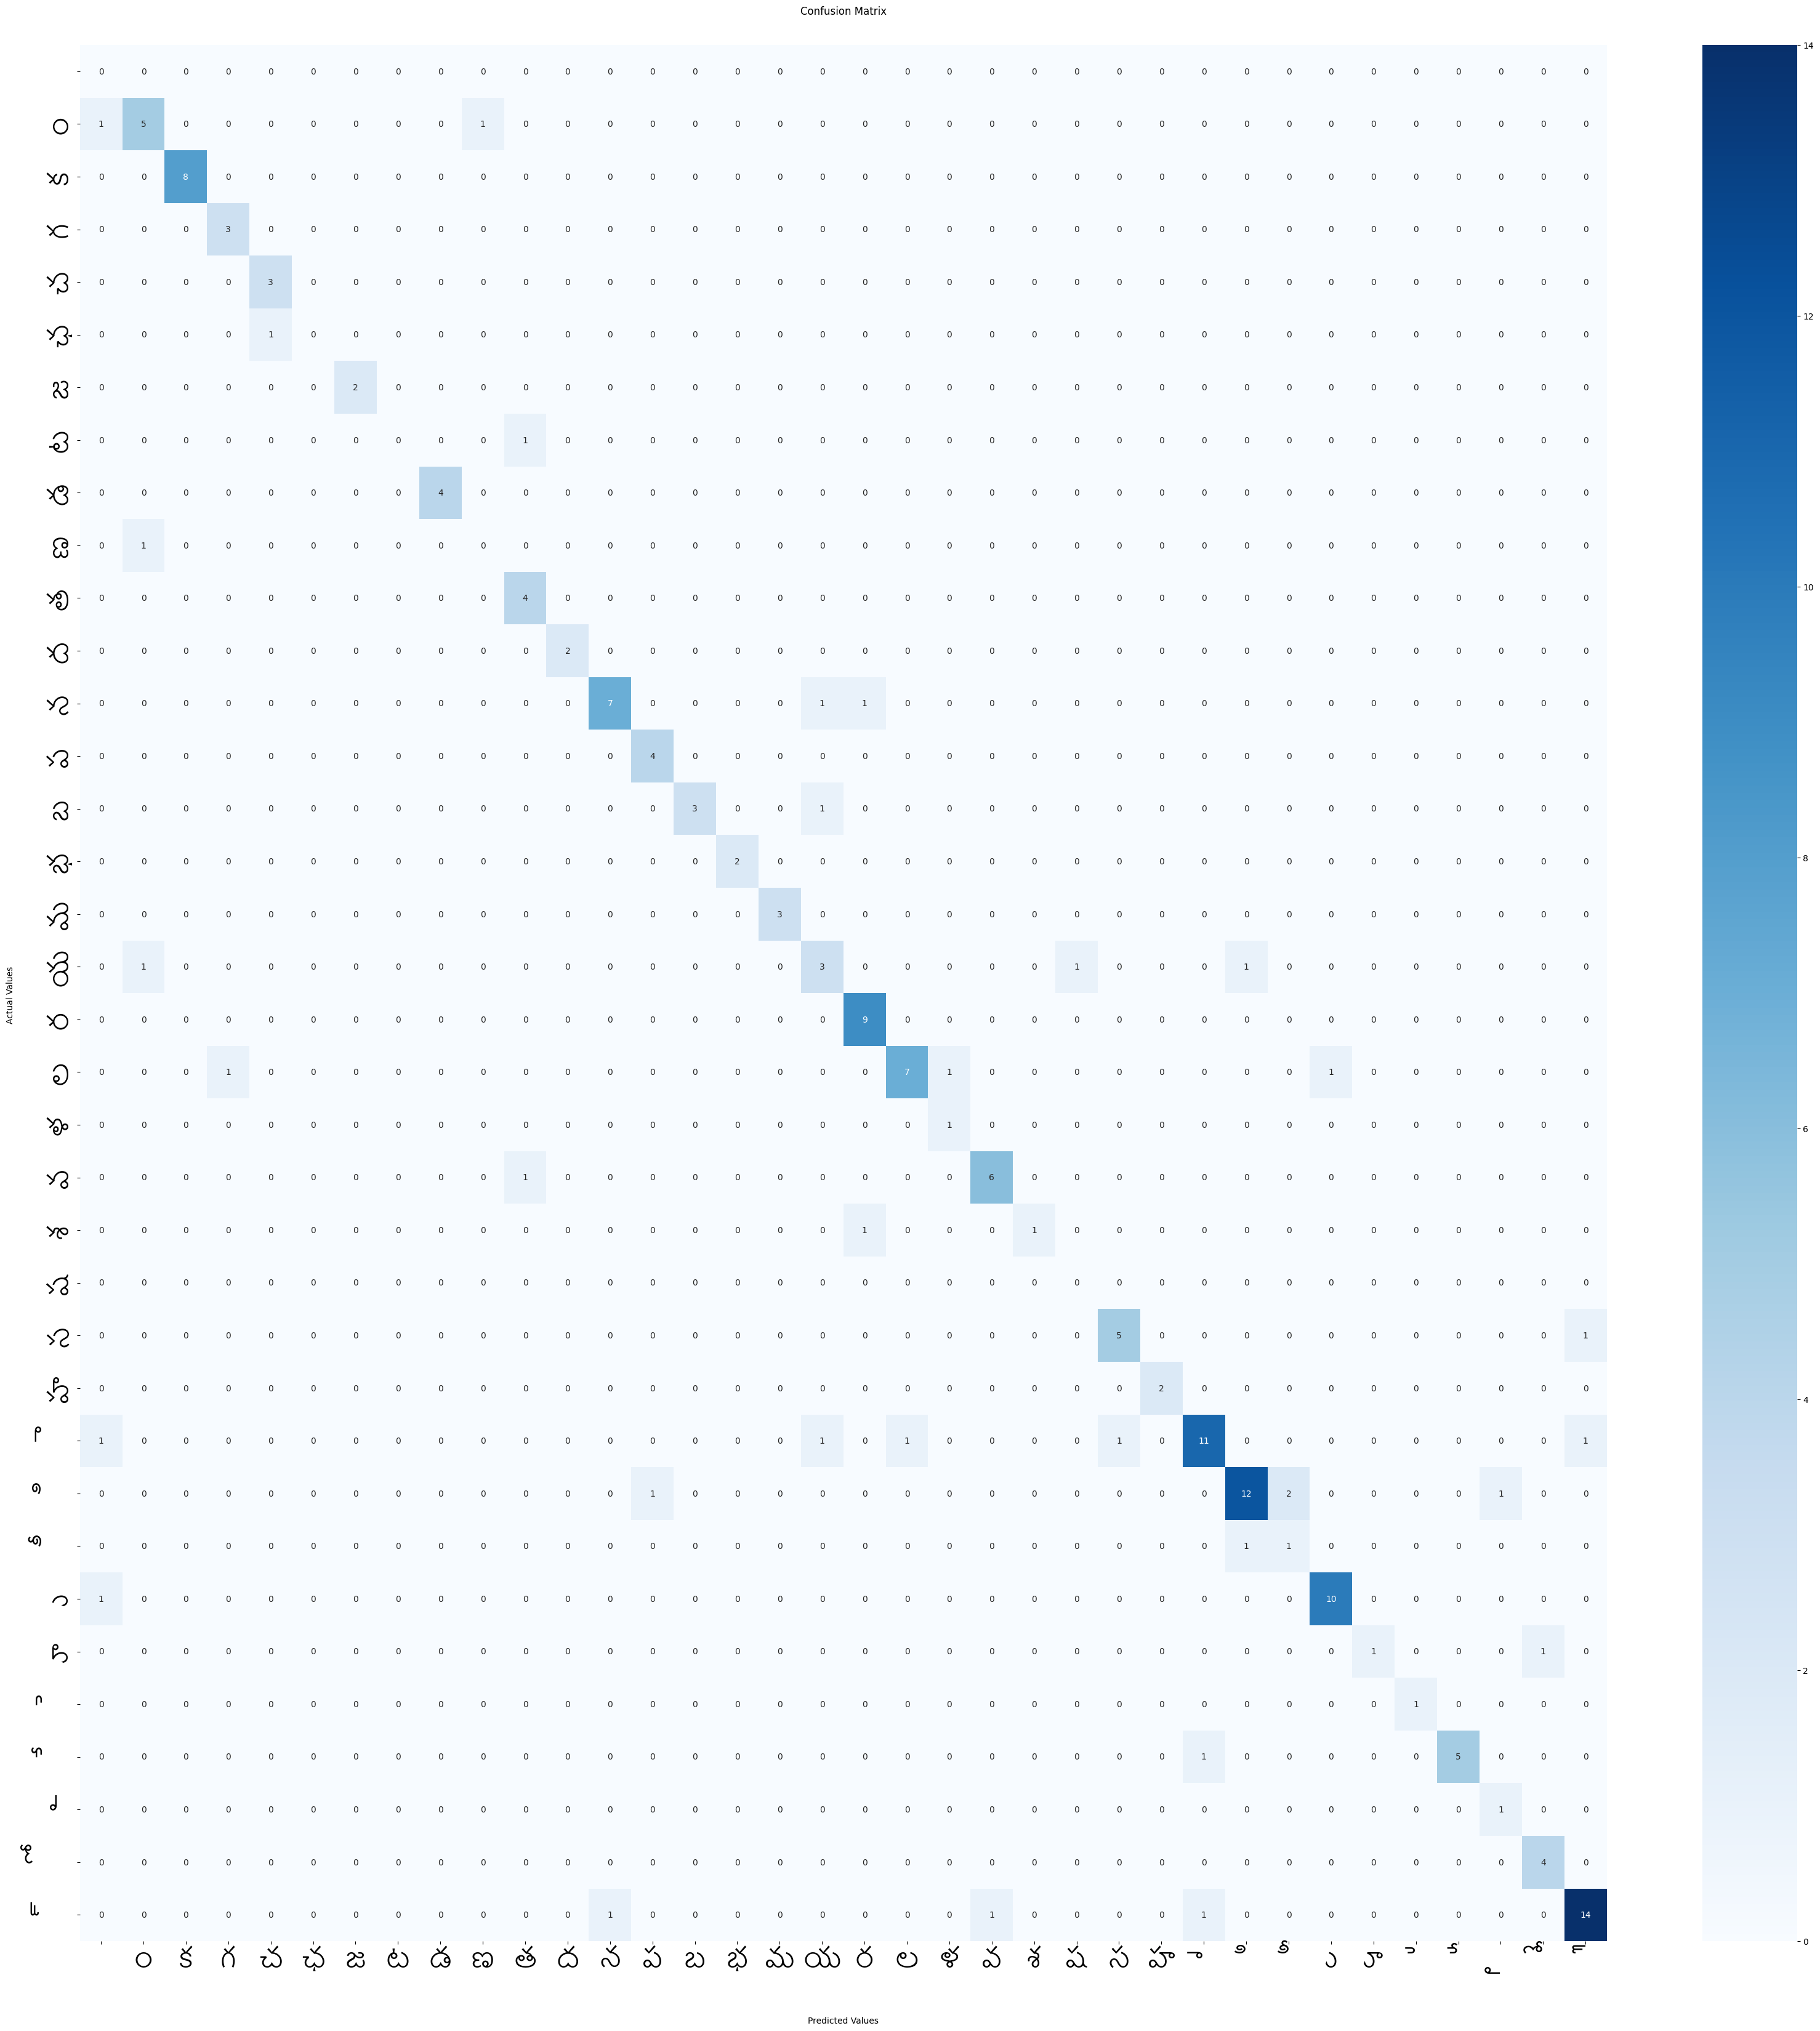

In [32]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
labelspred=[]
labelstrue=[]
for i,j in zip(predchar,tgtchar):
  if( i.strip()!=''  )  :
    labelspred.append(i)
    labelstrue.append(j)
import matplotlib.ticker as mticker
from matplotlib.font_manager import FontProperties
hindi_font = FontProperties(fname = 'Nirmala.ttf')
fontdict = {'fontsize': 30}
data = confusion_matrix(labelspred,labelstrue)


import seaborn as sns
fig = plt.figure(figsize=(40,40))
ax = sns.heatmap(data, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.set_xticklabels(np.unique(labelstrue+labelspred),fontdict=fontdict,fontproperties=hindi_font)
ax.set_yticklabels(np.unique(labelstrue+labelspred),fontdict=fontdict,fontproperties=hindi_font)

## Display the visualization of the Confusion Matrix.
plt.show()

### Word level Accuracy

In [33]:
maxlengthword=0
for i in actual:
  if(len(i)>maxlengthword):
    maxlengthword=len(i)


In [34]:
match=0
total=0
for i,j in zip(actual,predict):
  total+=1
  if(i==j):
    match+=1

print('word level accuracy '+str(match*100/total))

word level accuracy 45.18879415347138


In [35]:

df_vn = pd.read_csv('predictions_vanilla.csv')
source_vn=df_vn["inputs"]
actual_vn=df_vn["targets"]
predict_vn=df_vn["outputs"]

In [36]:

total_words=np.zeros(maxlengthword+1)
total_correct=np.zeros(maxlengthword+1)
total_wrong=np.zeros(maxlengthword+1)


total_words_vn=np.zeros(maxlengthword+1)
total_correct_vn=np.zeros(maxlengthword+1)
total_wrong_vn=np.zeros(maxlengthword+1)


html_str = """
    <br>
      <table style="border:2px solid black; border-collapse:collapse">
      <tr>
      <th scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>Word Length</strong> </th>
      <th scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>Total Words</strong> </th>
      <th scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>Accuracy With out Attention</strong> </th>
      <th scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>Accuracy With Attention</strong> </th></tr>

      """
for (i,j,k,l) in zip(actual,predict,actual_vn,predict_vn):
  total_words[len(i)]+=1
  total_words_vn[len(i)]+=1
  if(i==j):
    total_correct[len(i)]+=1
  else:
    total_wrong[len(i)]+=1
  if(k==l):
    total_correct_vn[len(k)]+=1
  else:
    total_wrong_vn[len(k)]+=1

for i in range(maxlengthword):

  if(total_words[i]!=0):
    html_str+="""<tr> <td scope="row" style="border:1px solid black;padding:10px;text-align:left"> <strong>{}</strong> </td>
      <td scope="row" style="border:1px solid black;padding:10px;text-align:left"> <strong>{}</strong> </td>
      <td scope="row" style="border:1px solid black;padding:10px;text-align:left"> <strong>{}</strong> </td>
      <td scope="row" style="border:1px solid black;padding:10px;text-align:left"> <strong>{}</strong> </td></tr>
      """.format( str(i),str(int(total_words[i])),str("{:.2f}".format(total_correct_vn[i]*100/total_words_vn[i]) ), str("{:.2f}".format(total_correct[i]*100/total_words[i])))
html_str += """</tr></table>"""

display(html_print(html_str))


Word Length,Total Words,Accuracy With out Attention,Accuracy With Attention
1,5,0.00,20.00
2,13,0.00,46.15
3,102,0.00,30.39
4,496,0.00,41.13
5,581,0.00,46.82
6,1050,0.00,45.71
7,897,0.00,48.72
8,789,0.00,43.73
9,630,0.00,49.21
10,461,0.00,47.29


### Attention Heatup

In [37]:
import warnings
import matplotlib.ticker as mticker
from matplotlib.font_manager import FontProperties
warnings.filterwarnings('ignore')
def attention_heatmap(model, n):
    attention_word,attention_pred,attention_wegt=[],[],[]
    for i in range(n):
        source_word = str(source[i])
        pred,attn=model.translate(source_word,get_heatmap=True)
        attention_word.append(source_word)
        attention_pred.append(pred)
        attention_wegt.append(attn)


    for i in range(n):
        lst_array=[]
        for j in range(len(attention_wegt[i])):
          wgt=attention_wegt[i][j].numpy()[0]
          vstack = np.asarray (wgt).reshape(len(wgt))
          lst_array.append(vstack)
        lst_array=np.asarray(lst_array)
        sequence=attention_word[i]
        predicted_sequence=attention_pred[i]
        actualword=sequence
        predictedword=predicted_sequence
        sequence=[char for char in sequence]

        predicted_sequence=[char for char in predicted_sequence]

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1, 1, 1)

        ax.matshow(lst_array[: len(predicted_sequence),:len(sequence )], cmap='viridis')

        hindi_font = FontProperties(fname = 'Nirmala.ttf')
        fontdict = {'fontsize': 14}
        ax.set_xticks(np.arange(len( sequence)))
        ax.set_yticks(np.arange(len( predicted_sequence)))
        ax.set_xticklabels(sequence)
        ax.set_yticklabels(predicted_sequence,fontdict=fontdict,fontproperties=hindi_font)
        ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
        plt.title("Input: "+actualword+" Predicted: "+str(predictedword),fontproperties=hindi_font )
        plt.show()

In [38]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.font_manager import FontProperties
warnings.filterwarnings('ignore')

def attention_heatmap(model, n):
    attention_word, attention_pred, attention_wegt = [], [], []

    # Get translations and attention weights for n examples
    for i in range(n):
        source_word = str(source[i])
        pred, attn = model.translate(source_word, get_heatmap=True)
        attention_word.append(source_word)
        attention_pred.append(pred)
        attention_wegt.append(attn)

    # Create heatmaps for each example
    for i in range(n):
        # Process attention weights
        lst_array = []

        # Print the shape of the first attention weight tensor for debugging
        if i == 0 and len(attention_wegt[i]) > 0:
            first_weight = attention_wegt[i][0].numpy()
            print(f"First attention weight shape: {first_weight.shape}")

        for j in range(len(attention_wegt[i])):
            # Get the numpy array from the tensor
            x = attention_wegt[i][j].numpy()

            # Handle different shapes based on the tensor's dimensions
            if x.ndim == 3:  # Shape like (batch_size, target_len, source_len)
                if x.shape[0] == 1:  # If batch size is 1
                    x = x[0]  # Take the first batch
                else:
                    # If there are multiple batches, take the first one
                    x = x[0]
            elif x.ndim == 2:  # Already in correct 2D shape
                x = x
            elif x.ndim == 1:  # 1D array
                # For 1D array, reshape to 2D with one row
                x = x.reshape(1, -1)

            # Add to our list
            lst_array.append(x)

        # Stack arrays vertically if multiple timesteps
        if len(lst_array) > 1:
            lst_array = np.vstack(lst_array)
        elif len(lst_array) == 1:
            lst_array = lst_array[0]
        else:
            print(f"No attention weights for example {i}")
            continue

        # Print final array shape for debugging
        print(f"Example {i} - Final attention array shape: {lst_array.shape}")

        # Get input and output sequences
        sequence = attention_word[i]
        predicted_sequence = attention_pred[i]

        # Split into characters
        sequence_chars = [char for char in sequence]
        predicted_chars = [char for char in predicted_sequence]

        # Create figure
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)

        # Calculate the dimensions to plot
        if lst_array.ndim >= 2:
            # For 2D arrays, use rows and columns
            plot_height = min(lst_array.shape[0], len(predicted_chars))
            plot_width = min(lst_array.shape[1], len(sequence_chars))

            # Extract the subset of the array to plot
            plot_array = lst_array[:plot_height, :plot_width]
        else:
            # For 1D arrays, reshape to 2D
            plot_array = lst_array.reshape(1, -1)
            plot_height = 1
            plot_width = min(plot_array.shape[1], len(sequence_chars))
            plot_array = plot_array[:, :plot_width]

        # Create heatmap
        im = ax.matshow(plot_array, cmap='viridis')
        fig.colorbar(im)

        # Set up fonts
        try:
            hindi_font = FontProperties(fname='Nirmala.ttf')
        except:
            hindi_font = FontProperties()

        fontdict = {'fontsize': 14}

        # Set axis labels
        ax.set_xticks(np.arange(plot_width))
        ax.set_yticks(np.arange(plot_height))
        ax.set_xticklabels(sequence_chars[:plot_width])

        # Handle case where prediction is shorter than attention matrix
        if len(predicted_chars) < plot_height:
            # Pad with empty strings if needed
            padded_pred_chars = predicted_chars + [''] * (plot_height - len(predicted_chars))
            ax.set_yticklabels(padded_pred_chars, fontdict=fontdict, fontproperties=hindi_font)
        else:
            ax.set_yticklabels(predicted_chars[:plot_height], fontdict=fontdict, fontproperties=hindi_font)

        # Set major ticks
        ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(mticker.MultipleLocator(1))

        # Title and layout
        plt.title(f"Input: {sequence} Predicted: {predicted_sequence}", fontproperties=hindi_font)
        plt.tight_layout()

        plt.show()

First attention weight shape: (1, 1, 25)
Example 0 - Final attention array shape: (6, 25)


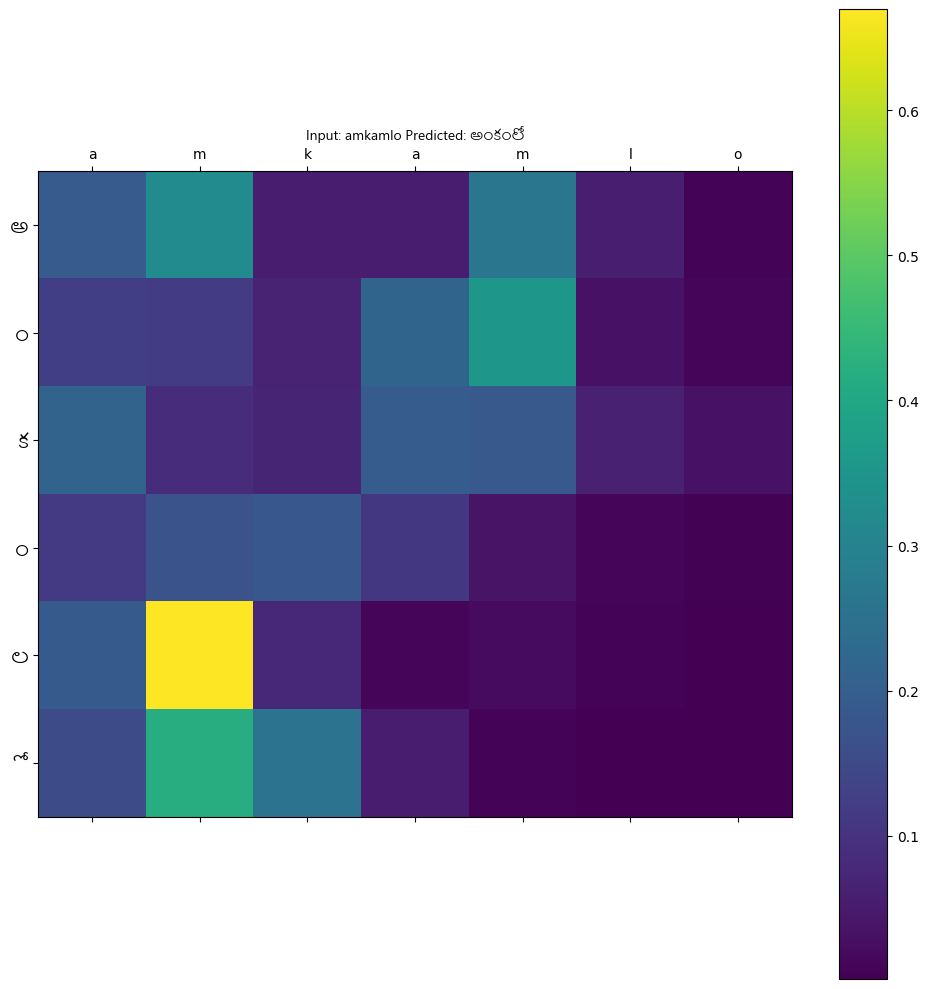

Example 1 - Final attention array shape: (6, 25)


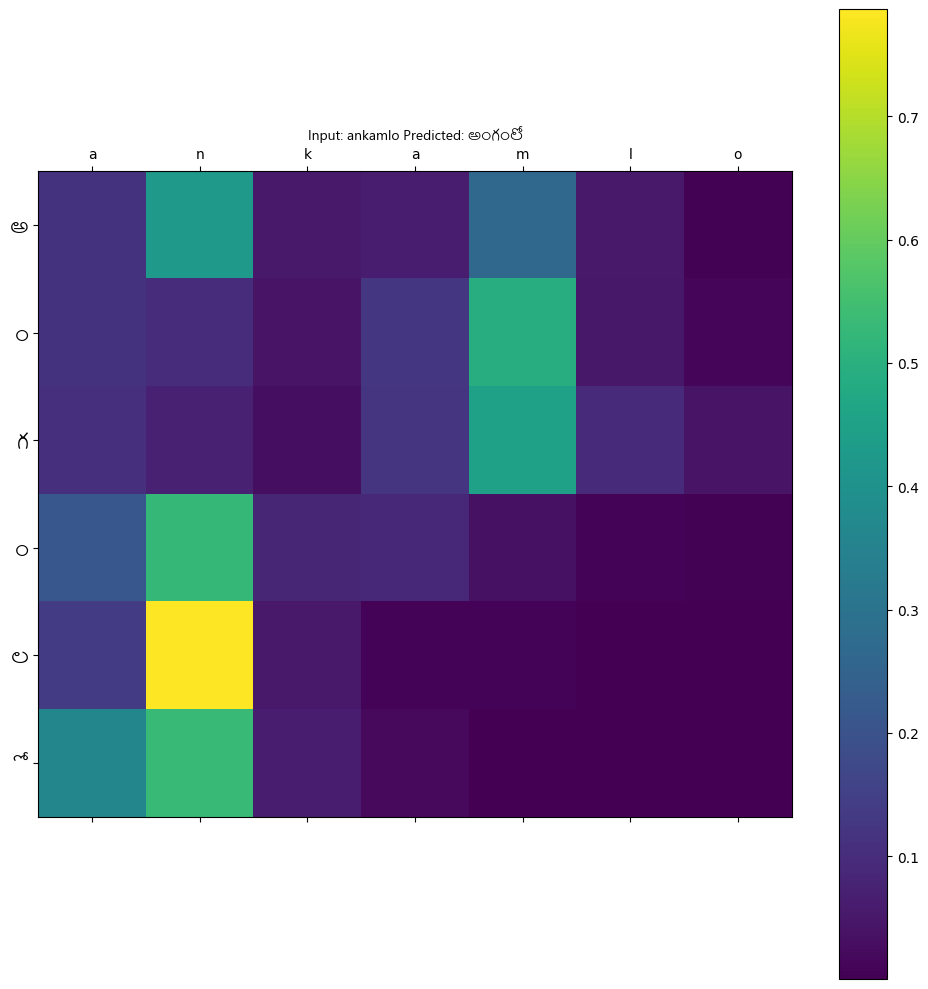

Example 2 - Final attention array shape: (6, 25)


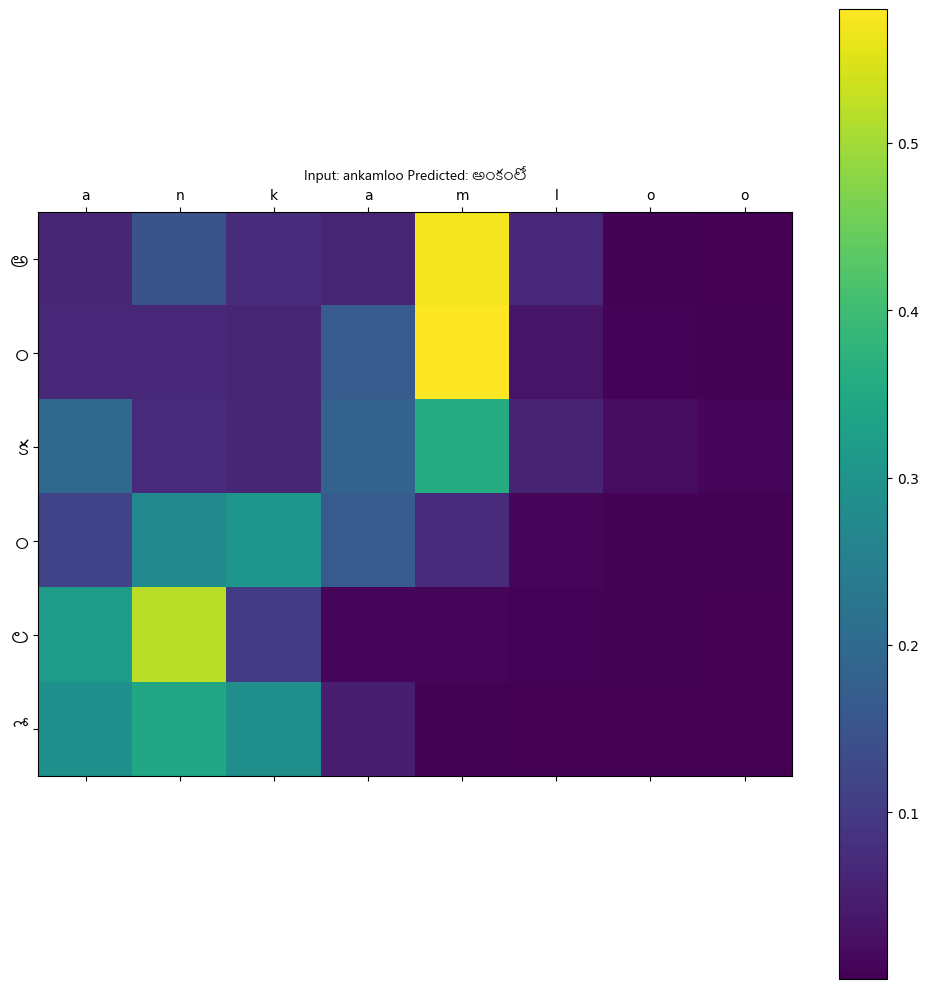

Example 3 - Final attention array shape: (7, 25)


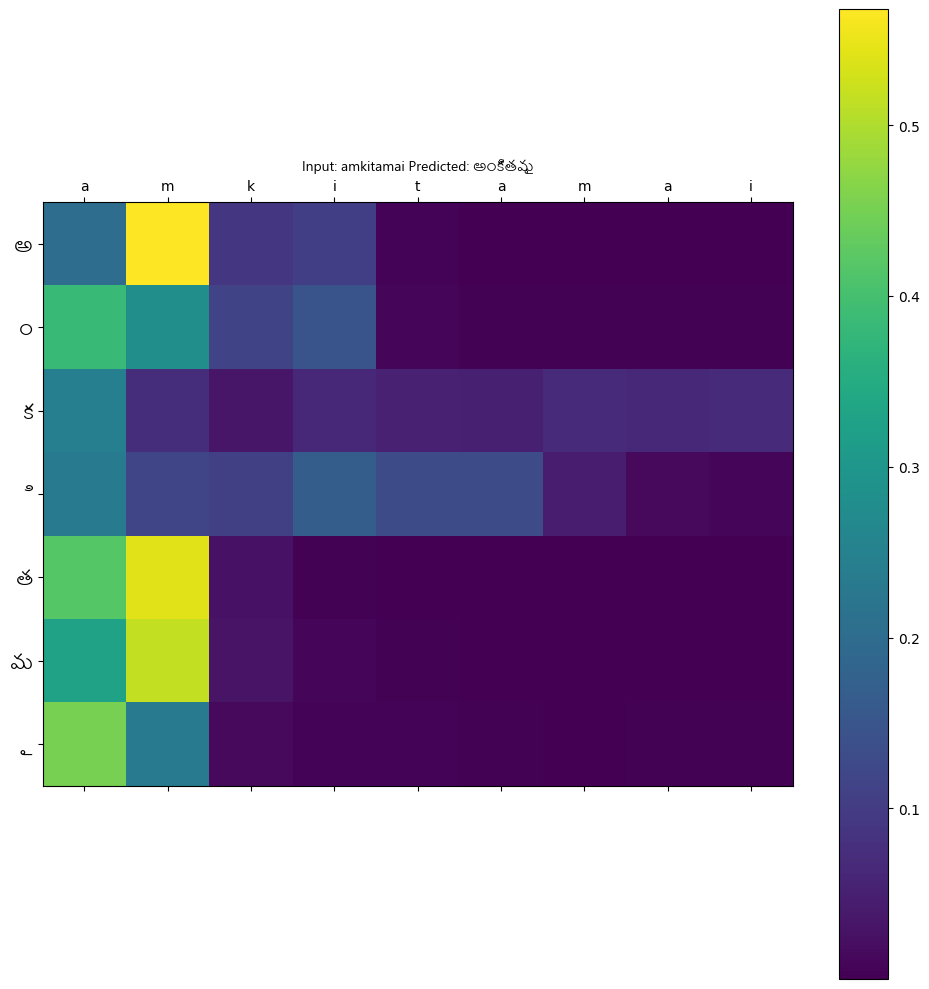

Example 4 - Final attention array shape: (7, 25)


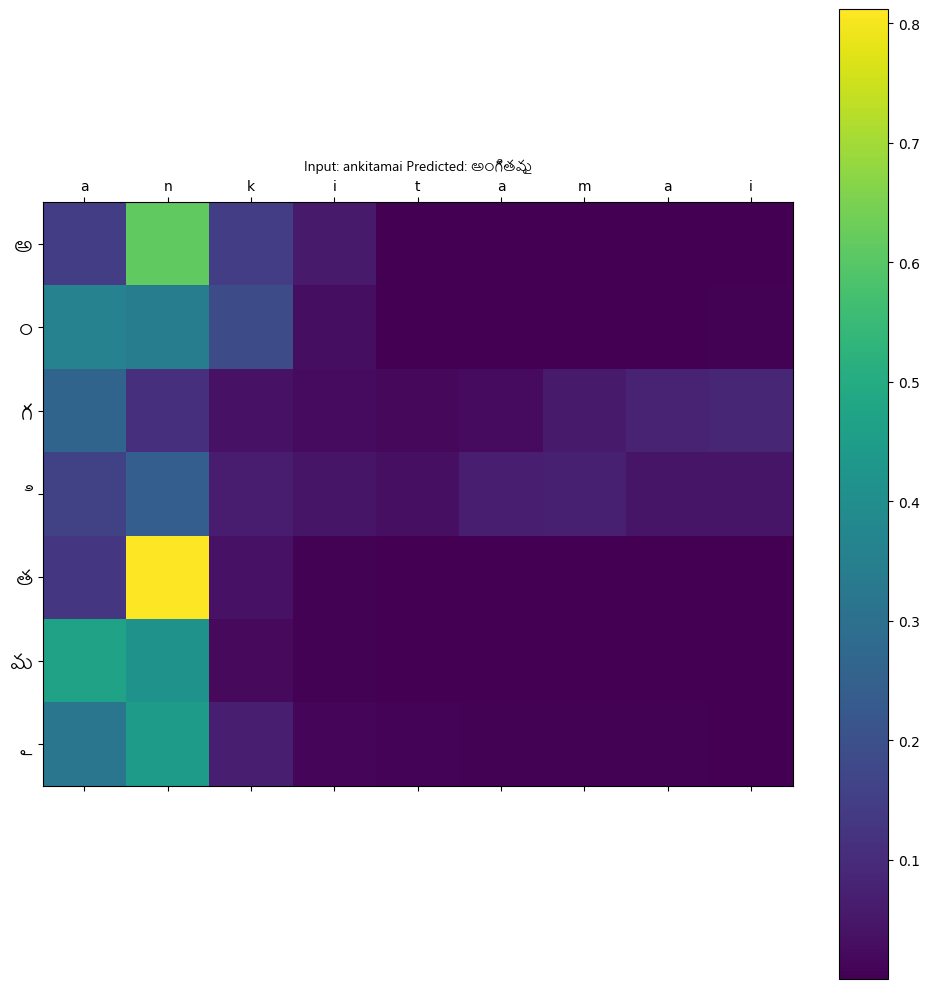

Example 5 - Final attention array shape: (6, 25)


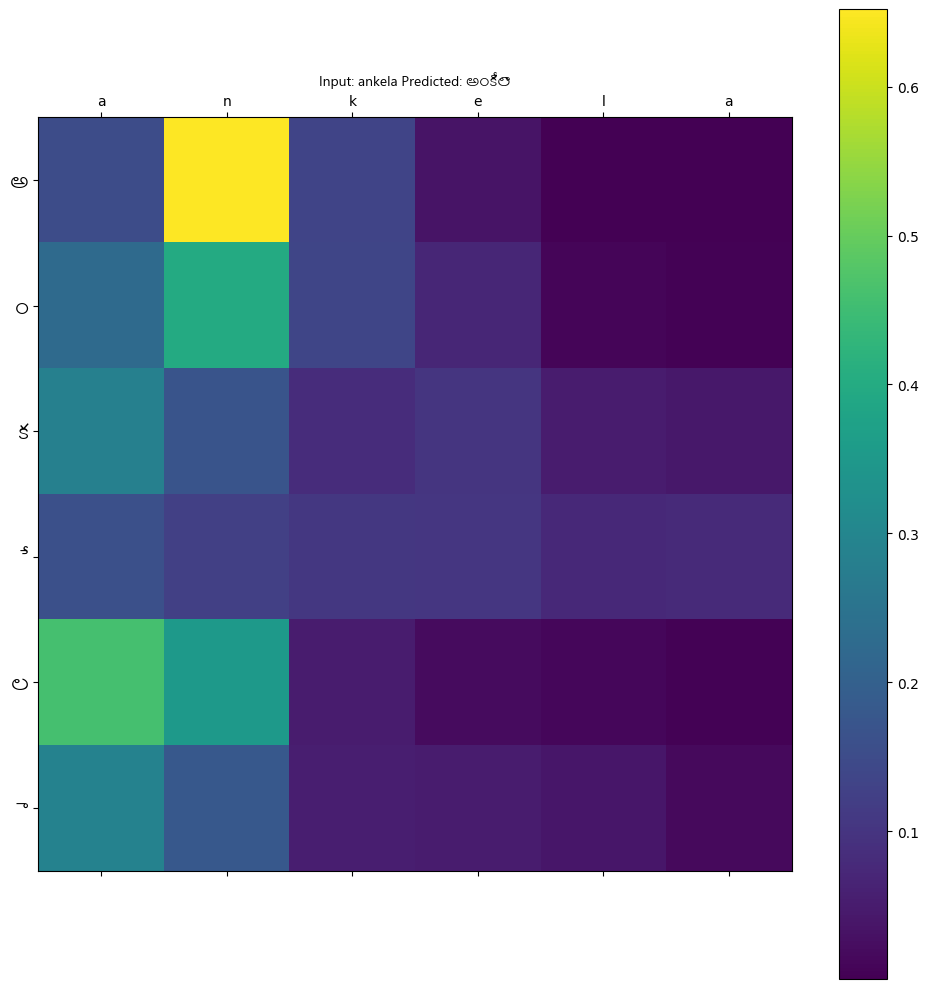

Example 6 - Final attention array shape: (7, 25)


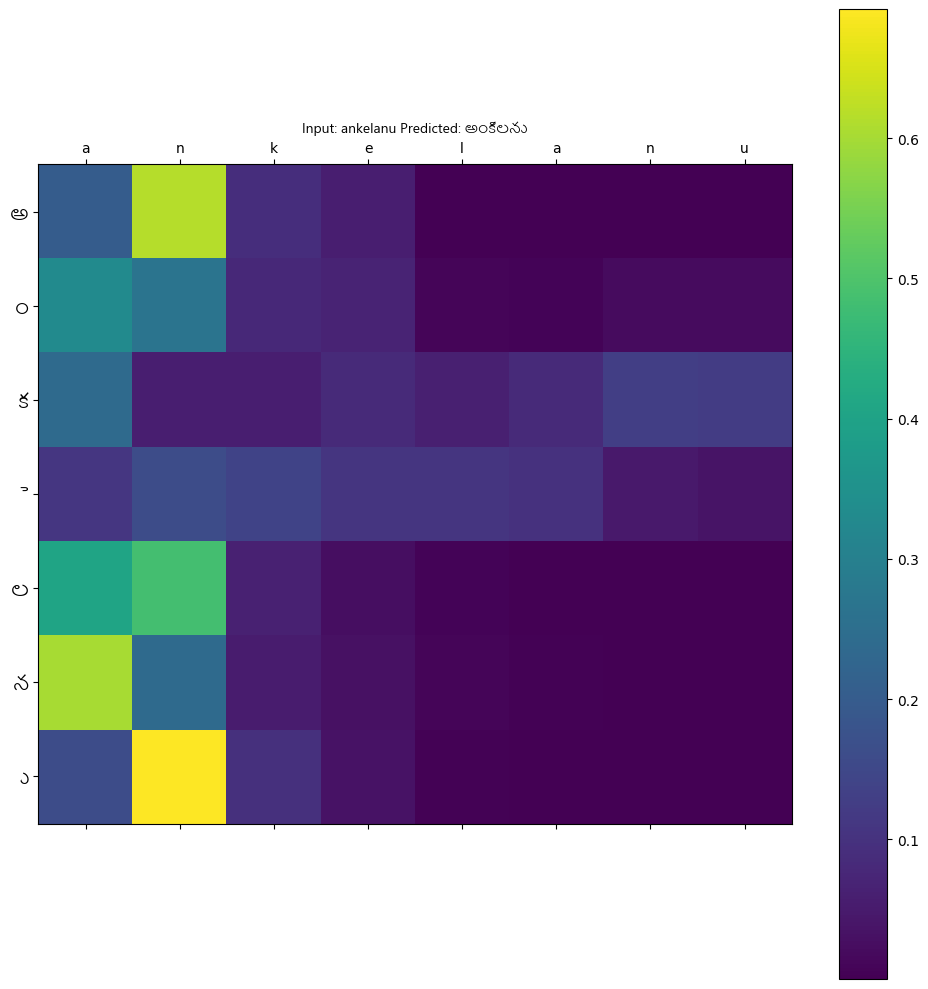

Example 7 - Final attention array shape: (9, 25)


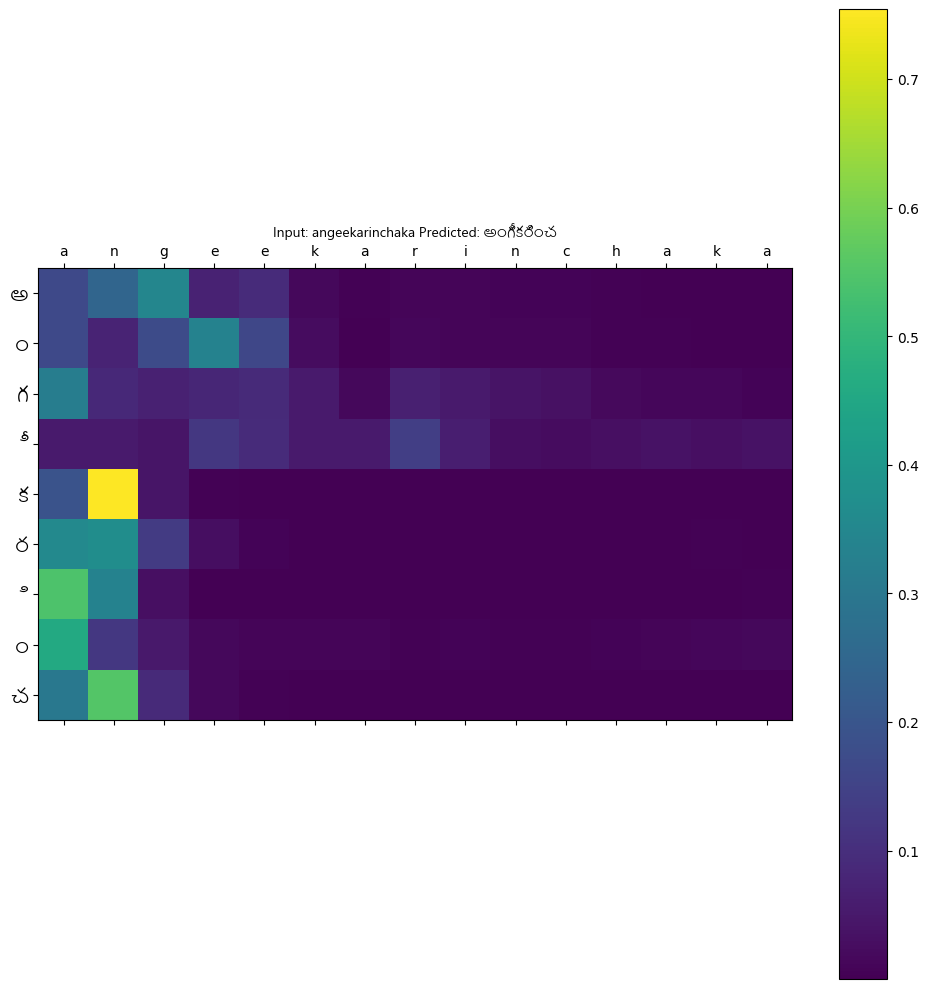

Example 8 - Final attention array shape: (12, 25)


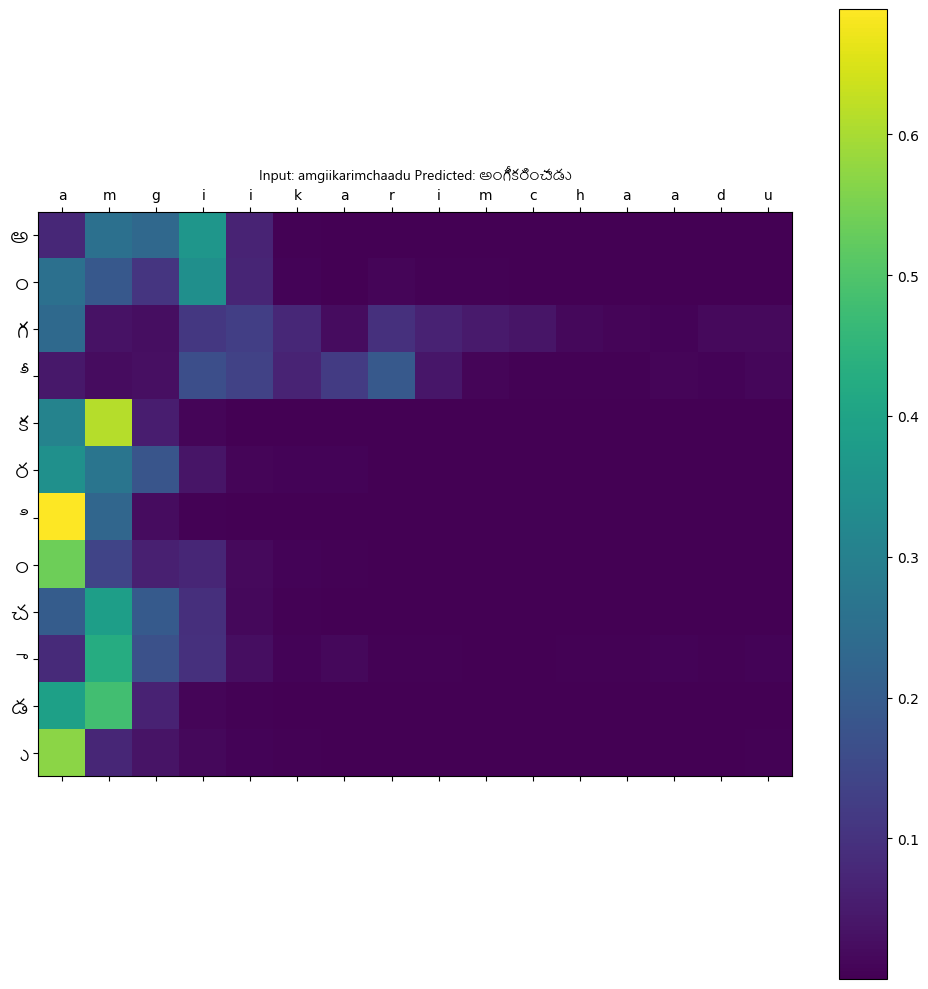

Example 9 - Final attention array shape: (12, 25)


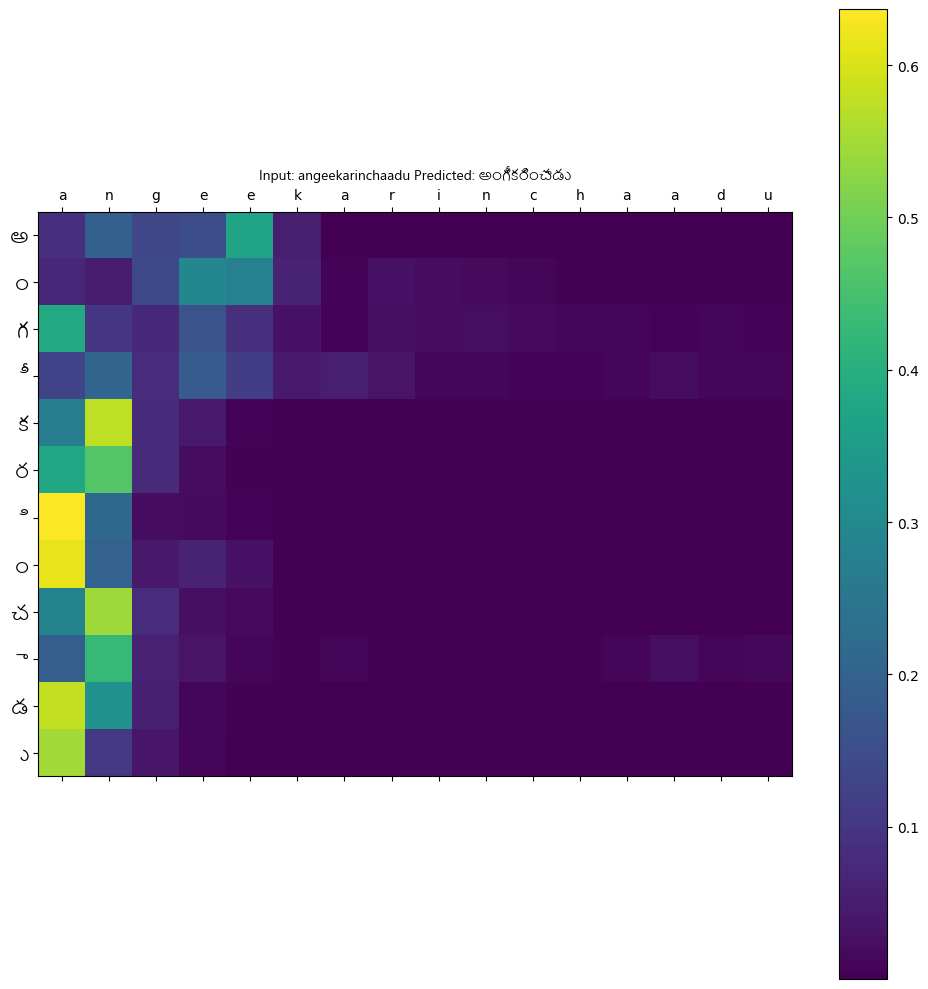

In [39]:
attention_heatmap(model,10)


### Visualise

In [40]:
def get_words_randomly_from_test(model, n):
    attention_word,attention_pred,attention_wegt=[],[],[]
    dir=get_files("te")
    test_df = pd.read_csv(dir[2],sep="\t",header=None)
    sample = test_df.sample(n)
    words = []
    for i,j in enumerate(sample[1]):
        source_word = j
        pred,attn=model.translate(source_word,get_heatmap=True)
        attention_word.append(source_word)
        attention_pred.append(pred)
        attention_wegt.append(attn)
    return attention_word,attention_pred,attention_wegt
attention_word,attention_pred,attention_wegt=get_words_randomly_from_test(model,1)

In [41]:
def sort_index(lst, rev=True):
    index = range(len(lst))
    s = sorted(index, reverse=rev, key=lambda i: lst[i])
    return s



In [42]:
import numpy as np

# First, let's check the shape of your attention weights
def diagnose_attention_weights(attention_wegt):
    print("Number of attention weight tensors:", len(attention_wegt[0]))

    # Print the shape of each attention weight tensor
    for j in range(len(attention_wegt[0])):
        x = attention_wegt[0][j].numpy()
        print(f"Tensor {j} shape: {x.shape}")
        print(f"Tensor {j} dimensions: {x.ndim}")

    # Try to properly process the attention weights
    lst_array = []
    for j in range(len(attention_wegt[0])):
        x = attention_wegt[0][j].numpy()

        # Based on the error, x is likely shape (batch_size, 1, source_len)
        # or similar with 25 total elements

        # Method 1: Flatten the array completely
        flattened = x.flatten()
        print(f"Tensor {j} flattened shape: {flattened.shape}")

        # Method 2: If x is shape (batch_size, target_len, source_len),
        # we want to extract just the attention weights
        if x.ndim == 3:
            # Extract first batch, all attention weights
            reshaped = x[0, :, :]
            print(f"Tensor {j} batch-extracted shape: {reshaped.shape}")
        elif x.ndim == 2:
            # Already in the right shape
            reshaped = x
            print(f"Tensor {j} is already 2D: {reshaped.shape}")
        else:
            # Try to intelligently reshape based on total elements
            total_elements = x.size
            if total_elements == 25:  # Assuming source sequence length is 25
                reshaped = x.reshape(-1, 25)
                print(f"Tensor {j} intelligently reshaped: {reshaped.shape}")
            else:
                # Last resort - keep as is
                reshaped = x
                print(f"Tensor {j} keeping original shape: {reshaped.shape}")

        lst_array.append(reshaped)

    # Convert to numpy array
    lst_array = np.array(lst_array)
    print("Final array shape:", lst_array.shape)

    return lst_array

In [43]:
# final_index=[]
# lst_array=[]
# for j in range(len(attention_wegt[0])):
#   x=attention_wegt[0][j].numpy()
#   x=x.reshape(x.shape[1])
#   wgt=x

#   lst_array.append(wgt)
# lst_array=np.asarray(lst_array)


In [44]:
lst_array = diagnose_attention_weights(attention_wegt)

Number of attention weight tensors: 5
Tensor 0 shape: (1, 1, 25)
Tensor 0 dimensions: 3
Tensor 1 shape: (1, 1, 25)
Tensor 1 dimensions: 3
Tensor 2 shape: (1, 1, 25)
Tensor 2 dimensions: 3
Tensor 3 shape: (1, 1, 25)
Tensor 3 dimensions: 3
Tensor 4 shape: (1, 1, 25)
Tensor 4 dimensions: 3
Tensor 0 flattened shape: (25,)
Tensor 0 batch-extracted shape: (1, 25)
Tensor 1 flattened shape: (25,)
Tensor 1 batch-extracted shape: (1, 25)
Tensor 2 flattened shape: (25,)
Tensor 2 batch-extracted shape: (1, 25)
Tensor 3 flattened shape: (25,)
Tensor 3 batch-extracted shape: (1, 25)
Tensor 4 flattened shape: (25,)
Tensor 4 batch-extracted shape: (1, 25)
Final array shape: (5, 1, 25)


In [45]:
print(lst_array.shape)

(5, 1, 25)


In [46]:
lst_array=lst_array[:len(attention_pred[0]),:len(attention_word[0])]


In [48]:
top_attn_index = []
top_attn_color = []

for i in range(len(lst_array)):
    # Get the indices of the top 3 values (or fewer if array is smaller)
    max_indices = sort_index(lst_array[i])[:min(3, len(lst_array[i]))]
    top_attn_index.append(max_indices)

    # Calculate softmax of the top attention values
    tmp = np.exp(np.array([lst_array[i][j] for j in max_indices]))
    top_attn = tmp / np.sum(tmp)

    # Define colors based on the number of elements in top_attn
    colours = ['#FF5F5F']  # First color is always the same

    # Add second color if it exists
    if len(top_attn) > 1:
        if top_attn[1] < 0.5:  # Changed from 50 to 0.5 as softmax gives values between 0 and 1
            colours.append('#FFB5B5')
        else:
            colours.append('#FFA3A3')

    # Add third color if it exists
    if len(top_attn) > 2:
        if top_attn[2] < 0.3:  # Changed from 30 to 0.3 as softmax gives values between 0 and 1
            colours.append('#FAE1E1')
        else:
            colours.append('#FCCDCD')

    # Fill remaining colors with default if we have fewer than 3 elements
    while len(colours) < 3:
        colours.append('#FFFFFF')  # Default color for missing elements

    top_attn_color.append(colours)

In [50]:
from IPython.display import HTML as html_print
from IPython.display import display
from IPython.display import clear_output
import time

def visualiser(word, predict, attention_colour, attention_index):
    i = 0
    for p in predict:
        html_str = """ <br/>
        <strong style="color:blue;padding:5px;font-size:20px;text-align:left">Word:</strong><strong style="font-size:20px">{}</strong>
        <br/><br/> <strong style="color:green;padding:5px;font-size:20px;text-align:left">Character Focused at Index:</strong><strong style="font-size:20px">{}</strong>
        <br/><br/>
        <table style="border:3px solid black;font-size:20px;border-collapse:collapse">
        <tr>
        <td scope="row" style="border:1px solid black;font-size:15px;background-color:#3498DB;color:white;padding:8px;text-align:left"><strong>Prediction</strong></td>
        """.format(word, i+1)

        html_str += """
        <td scope="row" style="border:1px solid black;font-size:20px;color:black;padding:8px;text-align:left"><div style="background-color:#E3FFE7">"""

        for w in range(len(predict)):
            if w <= i:
                html_str += """<strong style="background-color:#FBF7AB">{}</strong> """.format(predict[w])
            else:
                html_str += """<strong style="color:black">{}</strong> """.format(predict[w])

        html_str += """</div></td></tr>"""
        html_str += """<tr><td scope="row" style="border:1px solid black;font-size:20px;background-color:#3498DB;color:white;padding:5px;text-align:left"><strong>Attention</strong></td>
        <td scope="row" style="border:1px solid black;font-size:20px;color:black;padding:10px;text-align:left"><strong>{}</strong></td>
        </tr>
        """.format(predict[i])

        html_str += """
        <tr><td scope="row" style="border:1px solid black;font-size:20px;background-color:#3498DB;color:white;padding:10px;text-align:left"><strong>Visualisation</strong></td>
        <td scope="row" style="border:1px solid black;font-size:20px;color:black;padding:10px;text-align:left"><strong style="background-color:#E3FFE7">"""

        # Get the indices that exist for this iteration
        current_indices = attention_index[i]

        for w in range(len(word)):
            # Check if w matches any of the attention indices
            if len(current_indices) > 0 and w == current_indices[0]:
                html_str += """<strong style="background-color:{}">{}</strong>""".format(attention_colour[i][0], word[w])
            elif len(current_indices) > 1 and w == current_indices[1]:
                html_str += """<strong style="background-color:{}">{}</strong>""".format(attention_colour[i][1], word[w])
            elif len(current_indices) > 2 and w == current_indices[2]:
                html_str += """<strong style="background-color:{}">{}</strong>""".format(attention_colour[i][2], word[w])
            else:
                html_str += """<strong style="background-color:#F1FAED">{}</strong>""".format(word[w])

        html_str += """</strong></td></tr>"""
        html_str += """</table><br/><br/>"""

        display(html_print(html_str))

        clear_output(wait=True)
        time.sleep(0.8)
        i += 1

In [51]:

df = pd.read_csv('predictions_attention.csv')
source=df["inputs"]
actual=df["targets"]
predict=df["outputs"]



df = pd.read_csv('predictions_vanilla.csv')
source_vn=df["inputs"]
actual_vn=df["targets"]
predict_vn=df["outputs"]

In [52]:
source_rnd=[]
actual_rnd=[]
predict_rnd=[]
source_rnd_vn=[]
actual_rnd_vn=[]
predict_rnd_vn=[]
i=0
for i in range(len(source_vn)):
  i+=1
  if((actual_vn[i]!=predict_vn[i]) and (actual[i]==predict[i]) ):
    source_rnd.append(source[i])
    actual_rnd.append(actual[i])
    predict_rnd.append(predict[i])
    source_rnd_vn.append(source_vn[i])
    actual_rnd_vn.append(actual_vn[i])
    predict_rnd_vn.append(predict_vn[i])
    if(i>10):
      break

In [53]:
for i in range(len(actual_rnd_vn)):
  compare_result(predict_rnd_vn[i],actual_rnd_vn[i],source_rnd_vn[i],'Prediction Without Attention')
  compare_result(predict_rnd[i],actual_rnd[i],source_rnd[i],'Prediction With Attention')

అంకంలో,అ,ం,క,ం,ల,ో
ఆూ,ఆ,ూ,,,,
ankamloo,❌,❌,❌,❌,❌,❌


అంకంలో,అ,ం,క,ం,ల,ో
అంకంలో,అ,ం,క,ం,ల,ో
ankamloo,✅,✅,✅,✅,✅,✅


అంకితమై,అ,ం,క,ి,త,మ,ై
ఆూ,ఆ,ూ,,,,,
amkitamai,❌,❌,❌,❌,❌,❌,❌


అంకితమై,అ,ం,క,ి,త,మ,ై
అంకితమై,అ,ం,క,ి,త,మ,ై
amkitamai,✅,✅,✅,✅,✅,✅,✅


అంకితమై,అ,ం,క,ి,త,మ,ై
ఆూ,ఆ,ూ,,,,,
ankitamai,❌,❌,❌,❌,❌,❌,❌


అంకితమై,అ,ం,క,ి,త,మ,ై
అంకితమై,అ,ం,క,ి,త,మ,ై
ankitamai,✅,✅,✅,✅,✅,✅,✅


అంకెలను,అ,ం,క,ె,ల,న,ు
ఆూ,ఆ,ూ,,,,,
ankelanu,❌,❌,❌,❌,❌,❌,❌


అంకెలను,అ,ం,క,ె,ల,న,ు
అంకెలను,అ,ం,క,ె,ల,న,ు
ankelanu,✅,✅,✅,✅,✅,✅,✅


అంగీకరించక,అ,ం,గ,ీ,క,ర,ి,ం,చ,క
ఆూ,ఆ,ూ,,,,,,,,
angeekarinchaka,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌


అంగీకరించక,అ,ం,గ,ీ,క,ర,ి,ం,చ,క
అంగీకరించక,అ,ం,గ,ీ,క,ర,ి,ం,చ,క
angeekarinchaka,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅


అంగీకరించాడు,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,డ,ు
ఆూ,ఆ,ూ,,,,,,,,,,
amgiikarimchaadu,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌


అంగీకరించాడు,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,డ,ు
అంగీకరించాడు,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,డ,ు
amgiikarimchaadu,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅


అంగీకరించాడు,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,డ,ు
ఆూ,ఆ,ూ,,,,,,,,,,
angeekarinchaadu,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌


అంగీకరించాడు,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,డ,ు
అంగీకరించాడు,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,డ,ు
angeekarinchaadu,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅


అంగీకరించాడు,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,డ,ు
ఆూ,ఆ,ూ,,,,,,,,,,
angiikarinchaadu,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌


అంగీకరించాడు,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,డ,ు
అంగీకరించాడు,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,డ,ు
angiikarinchaadu,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅


అంగీకరించాలి,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,ల,ి
ఆూ,ఆ,ూ,,,,,,,,,,
angeekarinchaali,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌


అంగీకరించాలి,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,ల,ి
అంగీకరించాలి,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,ల,ి
angeekarinchaali,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅,✅
